In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
df = pd.read_csv("QS World University Rankings 2025 (Top global universities).csv", encoding='latin1')
df.columns = [c.replace(' ', '_').replace('=', '') for c in df.columns]

features = [
    'Academic_Reputation_Score', 'Employer_Reputation_Score', 
    'Faculty_Student_Score', 'Citations_per_Faculty_Score',
    'International_Faculty_Score', 'International_Students_Score',
    'International_Research_Network_Score', 'Employment_Outcomes_Score',
    'Sustainability_Score'
]

In [5]:
def clean_rank(rank_str):
    if isinstance(rank_str, str):
        match = re.search(r'(\d+)', rank_str)
        if match:
            return int(match.group(1))
    return rank_str

df['Rank_Num'] = df['RANK_2025'].apply(clean_rank)

In [6]:
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_ml = df[features].fillna(0)

print("Data Types after cleaning:")
print(df[features].dtypes)
print("\nFirst 5 ranks cleaned:", df['Rank_Num'].head().tolist())

Data Types after cleaning:
Academic_Reputation_Score               float64
Employer_Reputation_Score               float64
Faculty_Student_Score                   float64
Citations_per_Faculty_Score             float64
International_Faculty_Score             float64
International_Students_Score            float64
International_Research_Network_Score    float64
Employment_Outcomes_Score               float64
Sustainability_Score                    float64
dtype: object

First 5 ranks cleaned: [1, 2, 3, 4, 5]


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ml)

knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_scaled)

fake_user = pd.DataFrame([[10, 10, 10, 100, 10, 10, 10, 10, 10]], columns=features)
fake_user_scaled = scaler.transform(fake_user)

distances, indices = knn.kneighbors(fake_user_scaled)

print("Recommended Universities for 'Research Enthusiast':")
print(df.iloc[indices[0]][['Institution_Name', 'Citations_per_Faculty_Score']])

Recommended Universities for 'Research Enthusiast':
                                      Institution_Name  \
531      Indian Institute of Technology (BHU) Varanasi   
478  Indian Institute of Technology Indore (IIT Ind...   
636                      China University of Petroleum   
526      Missouri University of Science and Technology   
564       Nanjing University of Science and Technology   

     Citations_per_Faculty_Score  
531                         95.0  
478                         95.6  
636                         79.7  
526                         86.2  
564                         89.3  


In [8]:
df['Rank_Num'] = df['RANK_2025'].astype(str).str.extract('(\d+)').astype(float)
y = (df['Rank_Num'] <= 100).astype(int)

print(f"Distribution: {y.value_counts()}")

Distribution: Rank_Num
0    1403
1     100
Name: count, dtype: int64


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thant Thaw Tun\AppData\Local\Temp\ipykernel_20080\3816279144.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['Rank_Num'] = df['RANK_2025'].astype(str).str.extract('(\d+)').astype(float)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2%}")

Model Accuracy: 97.01%


In [14]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       281
           1       0.76      0.80      0.78        20

    accuracy                           0.97       301
   macro avg       0.87      0.89      0.88       301
weighted avg       0.97      0.97      0.97       301



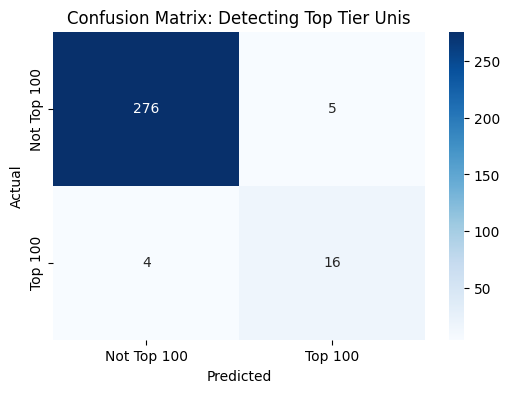

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Top 100', 'Top 100'], yticklabels=['Not Top 100', 'Top 100'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Detecting Top Tier Unis')
plt.show()

C:\Users\Thant Thaw Tun\AppData\Local\Temp\ipykernel_20080\1841569423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


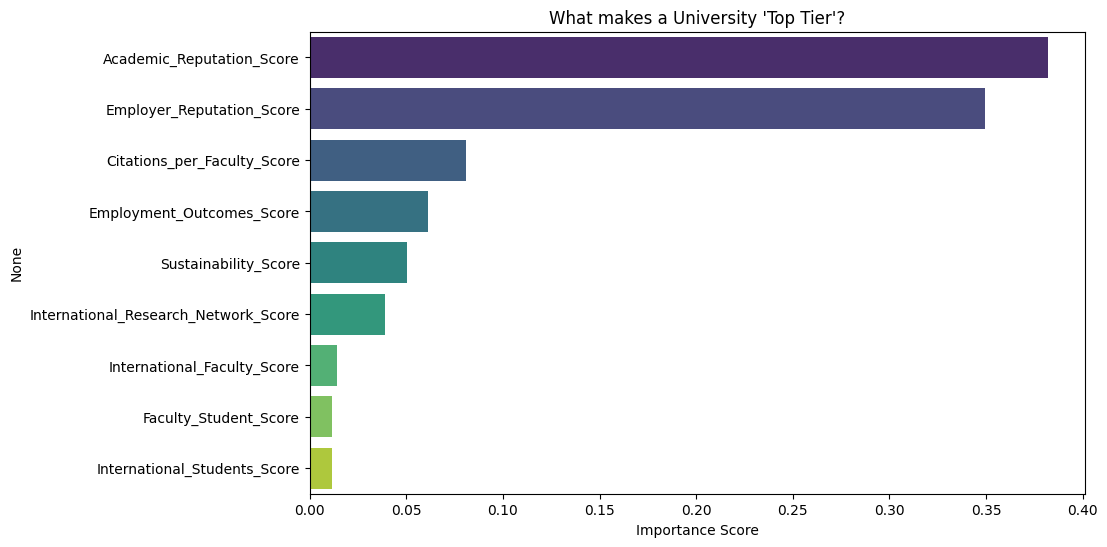

In [16]:
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("What makes a University 'Top Tier'?")
plt.xlabel("Importance Score")
plt.show()

In [17]:
import joblib
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(rf_model, 'rank_predictor.joblib')
joblib.dump(features, 'features.joblib')

['features.joblib']